In [ ]:
!nvidia-smi

Wed Oct 26 09:49:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import tensorflow as tf
#Deep Learning APIs for creating Neural Networks(Runs on Tensorflow)
from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow import math
from keras.utils.vis_utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Activation

# Scikit-learn : machine learning library
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# Used for accessing files and file names
import pathlib 
import os

In [ ]:
#func to grab random image from directory 
def display_random(dir,class_type):
   # Define directory to look in
    img_dir = dir + "/" + class_type
   # Get files from directory
    files = os.listdir(img_dir)
    
   # Pick a random image from that directory
    img_name = random.choice(files)
    
   # Read in the image
    img = mpimg.imread(img_dir + "/" + img_name)
    
   # Plot image with title & shape
    plt.imshow(img)
    plt.title(class_type)
    plt.axis("off");
    
   # Show the shape of the image
    print(f"Image shape: {img.shape}") 

   # So we can see how the computer sees the image
   # The image is understood as a big tensor with each pixel being
   # represented with RGB color amounts between 0 & 255
   # return img



Image shape: (1144, 1550)


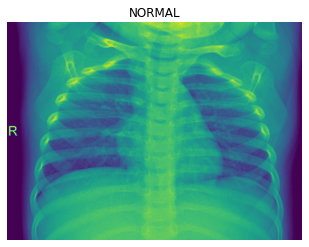

In [ ]:
display_random("/content/drive/MyDrive/data/chest_xray/train", "NORMAL")


Image shape: (697, 1033, 3)


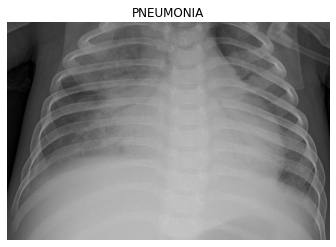

In [ ]:
display_random("/content/drive/MyDrive/data/chest_xray/train", "PNEUMONIA")

In [ ]:
training_data=tf.keras.utils.image_dataset_from_directory(directory="/content/drive/MyDrive/data/chest_xray/train",
                                                          batch_size=32,
                                                          image_size=(256,256),
                                                          seed=53)
valid_data=tf.keras.utils.image_dataset_from_directory(directory="/content/drive/MyDrive/data/chest_xray/val",
                                                          batch_size=16,
                                                          image_size=(256,256),
                                                          seed=53)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


In [ ]:
class_names = training_data.class_names #Get class names
print(class_names)

['NORMAL', 'PNEUMONIA']


In [ ]:
# Normalize pixel values between 0 & 1
# Each pixel is currently values between 0 & 255 for RGB colors
# Neural networks work best with normalized data
# Divide all values by the max value 255
norm_layer = tf.keras.layers.Rescaling(1/255.)
training_data_norm = training_data.map(lambda x, y: (norm_layer(x), y)) # Apply the division to all data in traing data set
valid_data_norm = valid_data.map(lambda x, y: (norm_layer(x), y)) # Do same for test (validation) dataset

In [ ]:
#Check for Normalization
image_batch, label_batch = next(iter(training_data_norm))
image_batch[0]

<tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
array([[[0.00433709, 0.00433709, 0.00433709],
        [0.02436619, 0.02436619, 0.02436619],
        [0.08057599, 0.08057599, 0.08057599],
        ...,
        [0.03529412, 0.03529412, 0.03529412],
        [0.01568628, 0.01568628, 0.01568628],
        [0.02359069, 0.02359069, 0.02359069]],

       [[0.0246515 , 0.0246515 , 0.0246515 ],
        [0.07935145, 0.07935145, 0.07935145],
        [0.10016181, 0.10016181, 0.10016181],
        ...,
        [0.03147308, 0.03147308, 0.03147308],
        [0.02224265, 0.02224265, 0.02224265],
        [0.02089461, 0.02089461, 0.02089461]],

       [[0.06216012, 0.06216012, 0.06216012],
        [0.09740446, 0.09740446, 0.09740446],
        [0.10735295, 0.10735295, 0.10735295],
        ...,
        [0.02745098, 0.02745098, 0.02745098],
        [0.02745098, 0.02745098, 0.02745098],
        [0.01954657, 0.01954657, 0.01954657]],

       ...,

       [[0.07058824, 0.07058824, 0.07058824],
        [0.06

In [ ]:
testing_data=tf.keras.utils.image_dataset_from_directory(directory="/content/drive/MyDrive/data/chest_xray/test",
                                                          batch_size=32,
                                                          image_size=(256,256),
                                                          seed=53)

Found 624 files belonging to 2 classes.


In [ ]:
test_data_norm = testing_data.map(lambda x, y: (norm_layer(x), y)) # Do same for test dataset

CNN model


In [ ]:
#Add more Data with Augmentation to avoid Overfitting
#Increasing the amount of data by adding slightly modified versions of existing data. Images are rotated, cropped, sheared, zoomed, flipped, etc.
# Augmenting this data doesn't change the images, but instead loads here when executed
data_augmentation =  Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [ ]:
tf.random.set_seed(72)
model = Sequential([
    data_augmentation,
    Conv2D(filters = 10,
           kernel_size = 3, # can also be (3, 3)
           input_shape = (256,256,3),
           activation = 'relu'), # first layer specifies input shape (height, width, colour channels)
    MaxPool2D(pool_size = 2, #or (2,2)
              padding = 'valid'), #or 'same'
    Conv2D(10, 3, activation = 'relu'), # Filters, Kernel Size, activation
    MaxPool2D(),
    Conv2D(10, 3, activation = 'relu'),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation = 'sigmoid') # Binary activation output layer
])
#Compile the Model 
model.compile(loss = 'binary_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])
#Fit the Model
hist = model.fit(training_data_norm,
                        steps_per_epoch = len(training_data_norm), #Steps through 50 batches of 32
                        epochs = 20,
                        validation_data = valid_data_norm, #Validate while fitting
                        validation_steps = len(valid_data_norm) # Steps through test data in batches of 32
                        )

Epoch 1/20
163/163 [==============================] - 48s 280ms/step - loss: 0.5070 - accuracy: 0.7703 - val_loss: 0.9119 - val_accuracy: 0.6250
Epoch 2/20
163/163 [==============================] - 39s 233ms/step - loss: 0.2908 - accuracy: 0.8738 - val_loss: 0.8726 - val_accuracy: 0.5625
Epoch 3/20
163/163 [==============================] - 38s 222ms/step - loss: 0.2593 - accuracy: 0.8930 - val_loss: 0.5849 - val_accuracy: 0.7500
Epoch 4/20
163/163 [==============================] - 38s 222ms/step - loss: 0.2269 - accuracy: 0.9064 - val_loss: 0.7448 - val_accuracy: 0.6875
Epoch 5/20
163/163 [==============================] - 38s 223ms/step - loss: 0.2057 - accuracy: 0.9176 - val_loss: 0.8425 - val_accuracy: 0.5625
Epoch 6/20
163/163 [==============================] - 41s 244ms/step - loss: 0.1964 - accuracy: 0.9206 - val_loss: 0.7095 - val_accuracy: 0.6875
Epoch 7/20
163/163 [==============================] - 38s 222ms/step - loss: 0.1868 - accuracy: 0.9237 - val_loss: 0.8839 - val_ac

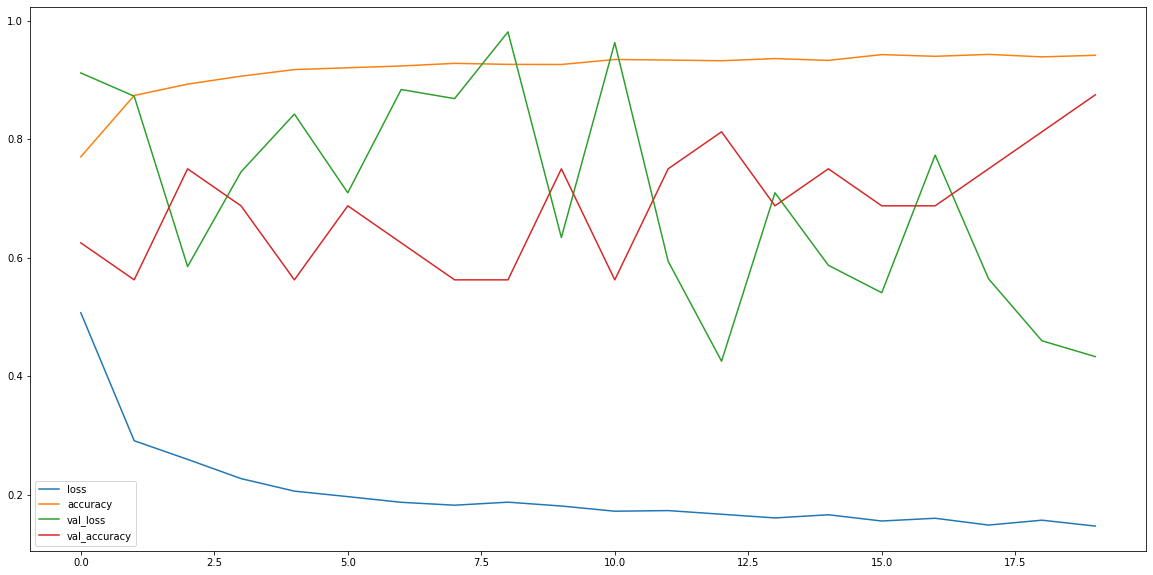

In [ ]:
pd.DataFrame(hist.history).plot(figsize = (20,10)) #Plot models training curves

In [ ]:
model.evaluate(test_data_norm)

20/20 [==============================] - 134s 4s/step - loss: 0.3032 - accuracy: 0.8798


[0.30324000120162964, 0.879807710647583]

In [ ]:
model.save("Pneumonia_Detection_CNN")

ResNet Feature Model

In [ ]:
import tensorflow_hub as hub # Provides pretrained models

In [ ]:
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"
# Download ResNet model and save as Keras layer
# Trainable : False means we don't want to train it further
resnet_layer = hub.KerasLayer(resnet_url,
                            trainable=False,
                            input_shape=(256,256,3))

# Create model
resnet_model=tf.keras.Sequential([
    # Puts images through downloaded model first
    resnet_layer,
    # Define we will use 2 classes
    Dense(1,
        activation="sigmoid")
])

In [ ]:
resnet_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              23564800  
                                                                 
 dense_6 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 23,566,849
Trainable params: 2,049
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
# Compile resnet Model
resnet_model.compile(loss="binary_crossentropy",
optimizer=tf.keras.optimizers.Adam(),
metrics=["accuracy"])

In [ ]:
# Fit Transfer Learning Model
resnet_history = resnet_model.fit(training_data_norm,
                                epochs=5,
                                steps_per_epoch=len(training_data_norm),
                                validation_data=valid_data_norm)

Epoch 1/5
163/163 [==============================] - 49s 236ms/step - loss: 0.1749 - accuracy: 0.9362 - val_loss: 0.3496 - val_accuracy: 0.9375
Epoch 2/5
163/163 [==============================] - 39s 230ms/step - loss: 0.1004 - accuracy: 0.9632 - val_loss: 0.3212 - val_accuracy: 0.9375
Epoch 3/5
163/163 [==============================] - 37s 221ms/step - loss: 0.0802 - accuracy: 0.9728 - val_loss: 0.3166 - val_accuracy: 0.9375
Epoch 4/5
163/163 [==============================] - 38s 225ms/step - loss: 0.0708 - accuracy: 0.9753 - val_loss: 0.3709 - val_accuracy: 0.8750
Epoch 5/5
163/163 [==============================] - 37s 215ms/step - loss: 0.0625 - accuracy: 0.9799 - val_loss: 0.2290 - val_accuracy: 0.9375


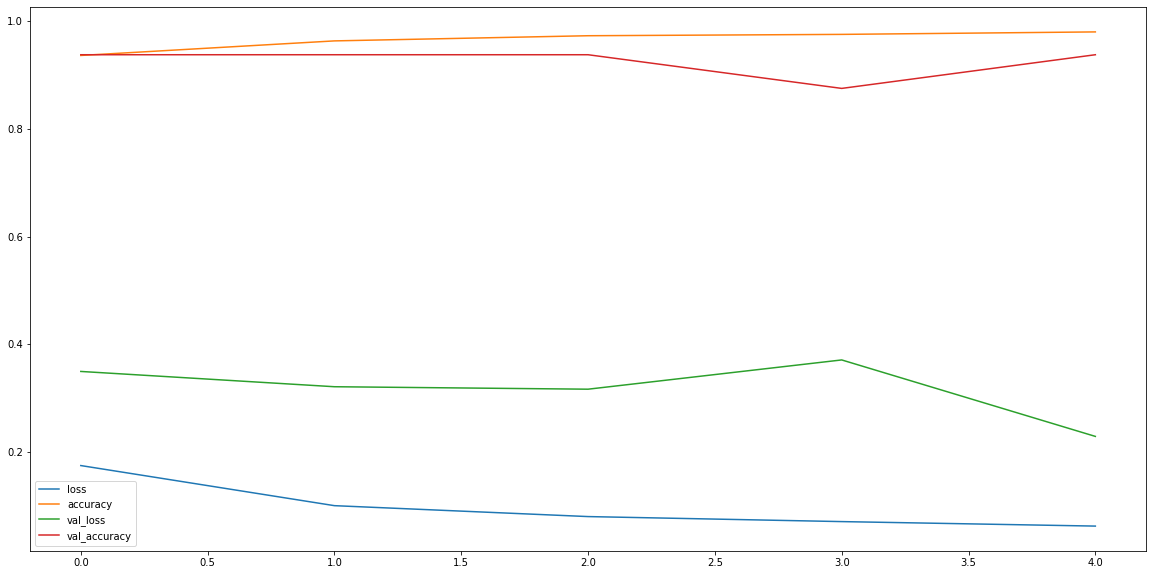

In [ ]:

pd.DataFrame(resnet_history.history).plot(figsize = (20,10)) #Plot models training curves

In [ ]:
resnet_model.evaluate(test_data_norm)

20/20 [==============================] - 4s 152ms/step - loss: 0.3806 - accuracy: 0.8590


[0.38058969378471375, 0.8589743375778198]

Efficient Net Feature Model

In [ ]:
eff_url = "https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1"
# Download EfficientNet model and save as Keras layer
# Trainable : False means we don't want to train it further
eff_layer = hub.KerasLayer(eff_url,
                            trainable=False,
                            input_shape=(256,256,3))

# Create model
eff_model=tf.keras.Sequential([
    # Puts images through downloaded model first
    eff_layer,
    # Define we will use 2 classes
    Dense(1,
        activation="sigmoid")
])

In [ ]:
# Compile EfficientNet Model
eff_model.compile(loss="binary_crossentropy",
optimizer=tf.keras.optimizers.Adam(),
metrics=["accuracy"])

In [ ]:
# Fit Transfer Learning Model
eff_history = eff_model.fit(training_data_norm,
                                epochs=5,
                                steps_per_epoch=len(training_data_norm),
                                validation_data=valid_data_norm)

Epoch 1/5
163/163 [==============================] - 110s 464ms/step - loss: 0.2272 - accuracy: 0.9133 - val_loss: 0.2279 - val_accuracy: 0.8750
Epoch 2/5
163/163 [==============================] - 74s 446ms/step - loss: 0.1285 - accuracy: 0.9546 - val_loss: 0.1688 - val_accuracy: 0.8750
Epoch 3/5
163/163 [==============================] - 76s 455ms/step - loss: 0.1080 - accuracy: 0.9628 - val_loss: 0.1714 - val_accuracy: 0.8750
Epoch 4/5
163/163 [==============================] - 76s 454ms/step - loss: 0.0957 - accuracy: 0.9664 - val_loss: 0.1486 - val_accuracy: 0.8750
Epoch 5/5
163/163 [==============================] - 76s 455ms/step - loss: 0.0882 - accuracy: 0.9689 - val_loss: 0.1347 - val_accuracy: 0.9375


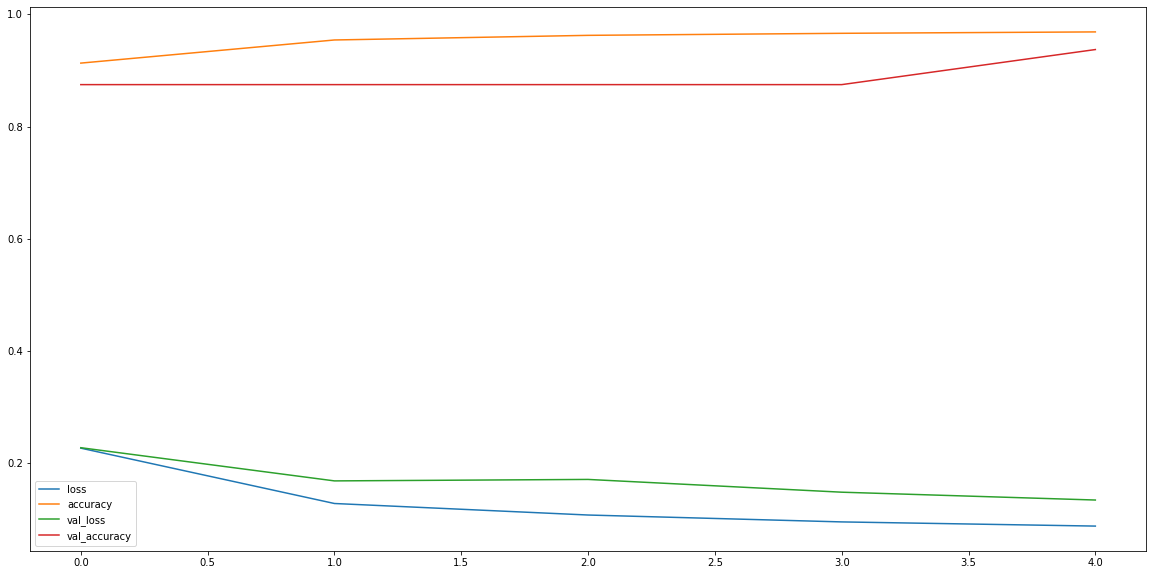

In [ ]:
pd.DataFrame(eff_history.history).plot(figsize = (20,10)) #Plot models training curves

In [ ]:
eff_model.evaluate(test_data_norm)

20/20 [==============================] - 10s 415ms/step - loss: 0.4725 - accuracy: 0.8189


[0.4724809229373932, 0.8189102411270142]